## Coursework Power System Expansion

### 1. Load packages

In [26]:
using JuMP, HiGHS
using Plots;
using DataFrames, CSV, Statistics 

### 2. Load and format data

In [27]:
#Generate the dataframes from the data
generators= DataFrame(CSV.File("GEN_USA_scenario2.csv"))
cf = DataFrame(CSV.File("cf.csv"))
demand = DataFrame(CSV.File("USA_Load_2050.csv"))
storage = DataFrame(CSV.File("storage_USA.csv"))

#Value Of Lost Load
VOLL = 35000

#Display input dataframes
display(generators)
display(cf)
display(demand)
display(storage)

8×11 DataFrame
 Row │ node   plant_id  Pmax            source   type           Fixed_Cost_Lif ⋯
     │ Int64  Int64     Float64         String7  String15       Int64          ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1         1   18988.9        ng       ng_ccs_WECC                26 ⋯
   2 │     1         2       1.37835e5  nuclear  nuclear_WECC               54
   3 │     1         3       0.0        wind     wind_WECC                  16
   4 │     1         4  153656.0        solar    solar_WECC                 11
   5 │     2         5   15445.7        ng       ng_ccs_ERCOT               26 ⋯
   6 │     2         6   16674.2        wind     wind_ERCOT                 16
   7 │     2         7       0.0        solar    solar_ERCOT                11
   8 │     2         8   86274.8        nuclear  nuclear_ERCOT              54
                                                               6 columns omitted

8736×9 DataFrame
  Row │ Hours  ng_ccs_WECC  nuclear_WECC  wind_WECC  solar_WECC  ng_ccs_ERCOT  ⋯
      │ Int64  Int64        Int64         Float64    Float64     Int64         ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │     1            1             1      0.404   0.0                   1  ⋯
    2 │     2            1             1      0.478   0.0                   1
    3 │     3            1             1      0.515   0.0                   1
    4 │     4            1             1      0.6     0.0                   1
    5 │     5            1             1      0.481   0.0                   1  ⋯
    6 │     6            1             1      0.609   0.0                   1
    7 │     7            1             1      0.355   0.0                   1
    8 │     8            1             1      0.313   0.0346667             1
  ⋮   │   ⋮         ⋮            ⋮            ⋮          ⋮            ⋮        ⋱
 8730 │  8730            1             1      0.044   0.0                   1  ⋯
 8731 │  8731            1             1      0.061   0.0                   1
 8732 │  8732            1             1      0.075   0.0                   1
 8733 │  8733            1             1      0.076   0.0                   1
 8734 │  8734            1             1      0.086   0.0                   1  ⋯
 8735 │  8735            1             1      0.15    0.0                   1
 8736 │  8736            1             1      0.241   0.0                   1
                                                 3 columns and 8721 rows omitted

8736×3 DataFrame
  Row │ Hour   WECC_Load_MWh  ERCOT_Load_MWh_2050 
      │ Int64  Int64          Float64             
──────┼───────────────────────────────────────────
    1 │     1         144717        84664.0
    2 │     2         136577        92674.4
    3 │     3         134337        96704.3
    4 │     4         132281        97238.2
    5 │     5         131920        96100.1
    6 │     6         135740        97753.1
    7 │     7         142135        94796.7
    8 │     8         146883        93561.7
  ⋮   │   ⋮          ⋮                 ⋮
 8730 │  8730         230718            1.00573e5
 8731 │  8731         240372        95216.6
 8732 │  8732         236110        91925.8
 8733 │  8733         220313        89252.5
 8734 │  8734         196463        87789.5
 8735 │  8735         178436        84332.5
 8736 │  8736         165607        82891.8
                                 8721 rows omitted

6×13 DataFrame
 Row │ node   plant_id  SOCmax     hours  type           Fixed_Cost_Lifetime   ⋯
     │ Int64  Int64     Int64      Int64  String15       Int64                 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1         1  100000000      5  batteries                  2035000   ⋯
   2 │     1         2  100000000     12  hydro_storage               927000
   3 │     1         3     665900      5  EV_shift                         0
   4 │     2         4  100000000      5  batteries                  2035000
   5 │     2         5  100000000     12  hydro_storage               927000   ⋯
   6 │     2         6     266360      5  EV_shift                         0
                                                               7 columns omitted

### 3. Network model definition

In [28]:
#branch matrix
A = [
    1 -1
]

#Source used for transmission cost:
#https://en.wikipedia.org/wiki/Adelanto_Converter_Station
# times 2.36 to adjust for inflation from 1986

line = DataFrame(
    location = ["west-ercot"],
    id= [1],
    available_capacity = [1000000],
    CRF = (0.07*(1+0.07)^40)/(((1+0.07)^40)-1),
    line_cost = 131000000/1200 * 2.36 * 0.075
)

1×5 DataFrame
 Row │ location    id     available_capacity  CRF        line_cost 
     │ String      Int64  Int64               Float64    Float64   
─────┼─────────────────────────────────────────────────────────────
   1 │ west-ercot      1             1000000  0.0750091    19322.5

### 4. Definition of the different sets

In [29]:
# sets related to generation & storage
G = generators.plant_id;
T = generators.type;
STOR = storage.plant_id;

# time sets
H = cf.Hours;
H_2 = 2:8736;

# node set
N = 1:2;

# display 
display(G)
display(T)
display(STOR)
display(H)
display(N)

8-element Vector{Int64}:
 1
 2
 3
 4
 5
 6
 7
 8

8-element Vector{String15}:
 "ng_ccs_WECC"
 "nuclear_WECC"
 "wind_WECC"
 "solar_WECC"
 "ng_ccs_ERCOT"
 "wind_ERCOT"
 "solar_ERCOT"
 "nuclear_ERCOT"

6-element Vector{Int64}:
 1
 2
 3
 4
 5
 6

8736-element Vector{Int64}:
    1
    2
    3
    4
    5
    6
    7
    8
    9
   10
    ⋮
 8728
 8729
 8730
 8731
 8732
 8733
 8734
 8735
 8736

1:2

### 5. Solver used

In [30]:
Model_flow = direct_model(HiGHS.Optimizer())

A JuMP Model
├ mode: DIRECT
├ solver: HiGHS
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

### 6. Decision variables

In [31]:
@variables(Model_flow, begin
        CAP[g in G] >=0          # Generating capacity built (MW)
        GEN[g in G, h in H] >= 0 # Generation in each hour (MWh)
        0 <= NSE[h in H, n in N]       # Non-served energy in each hour (MWh)

        #storage
        0 <= CAP_STOR[s in STOR]  # Storage capacity installed (MWh)
        0 <= DISCHARGE[s in STOR, h in H]          # Power discharge (MW)
        0 <= CHARGE[s in STOR, h in H]              # Power charge (MW)
        0 <= SOC[s in STOR, h in H]              # Energy storage state of charge (MWh)

        #flow
        0 <= CAP_FLOW[1] <= line[line.id.==1,:available_capacity][1]      
        FLOW[h in H]

end)

Running HiGHS 1.9.0 (git hash: 66f735e60): Copyright (c) 2024 HiGHS under MIT licence terms


┌ Warning: Axis contains one element: 1. If intended, you can safely ignore this warning. To explicitly pass the axis with one element, pass `[1]` instead of `1`.
└ @ JuMP.Containers /Users/juanganzarainlarranaga/.julia/packages/JuMP/CU7H5/src/Containers/DenseAxisArray.jl:185


(1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, [1, 2, 3, 4, 5, 6, 7, 8]
And data, a 8-element Vector{VariableRef}:
 CAP[1]
 CAP[2]
 CAP[3]
 CAP[4]
 CAP[5]
 CAP[6]
 CAP[7]
 CAP[8], 2-dimensional DenseAxisArray{VariableRef,2,...} with index sets:
    Dimension 1, [1, 2, 3, 4, 5, 6, 7, 8]
    Dimension 2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  8727, 8728, 8729, 8730, 8731, 8732, 8733, 8734, 8735, 8736]
And data, a 8×8736 Matrix{VariableRef}:
 GEN[1,1]  GEN[1,2]  GEN[1,3]  GEN[1,4]  …  GEN[1,8735]  GEN[1,8736]
 GEN[2,1]  GEN[2,2]  GEN[2,3]  GEN[2,4]     GEN[2,8735]  GEN[2,8736]
 GEN[3,1]  GEN[3,2]  GEN[3,3]  GEN[3,4]     GEN[3,8735]  GEN[3,8736]
 GEN[4,1]  GEN[4,2]  GEN[4,3]  GEN[4,4]     GEN[4,8735]  GEN[4,8736]
 GEN[5,1]  GEN[5,2]  GEN[5,3]  GEN[5,4]     GEN[5,8735]  GEN[5,8736]
 GEN[6,1]  GEN[6,2]  GEN[6,3]  GEN[6,4]  …  GEN[6,8735]  GEN[6,8736]
 GEN[7,1]  GEN[7,2]  GEN[7,3]  GEN[7,4]     GEN[7,8735]  GEN[7,8736]
 GEN[8,1]  GEN[8,2]  GEN[8,3]  GEN[8,4]   

### 7. Constraints of the problem

In [32]:
@constraints(Model_flow, begin

    cFactor[g in G, h in H], GEN[g, h] <= CAP[g] * cf[h, T[g]]    #Constrain generation with associated capacity factors
    cCapacity[g in G, h in H], CAP[g] == generators.Pmax[g]       #Set the capacity to the values from scenario 1
    
    cNuclearCap[g in G, h in H; generators[generators.plant_id .== g, :source][1] == "nuclear"], GEN[g, h] >= 0.5*CAP[g] #Nuclear generation must be at least 50% of it's capacity
    cNuclearFlexibilityUp[g in G, h in H_2; generators[generators.plant_id .== g, :source][1] == "nuclear"], GEN[g,h] <= GEN[g, h-1]*(1+0.05) #Ramp up of maximum 5% per hour
    cNuclearFlexibilityDown[g in G, h in H_2; generators[generators.plant_id .== g, :source][1] == "nuclear"], GEN[g, h-1]*(1-0.05) <= GEN[g,h] #Ramp down of maximum 5% per hour

    #Supply demand balance includong NSE and storage, indexed by nodes
    cDemandBalance[h in H, n in N], sum(GEN[g, h] for g in G if generators.node[g]==n) + sum(DISCHARGE[s, h] - CHARGE[s, h] for s in STOR if storage.node[s] == n) + NSE[h,n] + sum(A[n]*FLOW[h]) == demand[h,n+1]
    
    #storage constraints
    cStateOfCharge[s in STOR, h in H_2], SOC[s,h] == SOC[s,h-1] + storage[storage.plant_id.==s,:Eff][1]*CHARGE[s,h] - DISCHARGE[s,h]/storage[storage.plant_id.==s,:Eff][1] # State of charge of storage units
    cStateOfCharge_max[s in STOR, h in H], SOC[s, h] <= CAP_STOR[s]
    cSOC1[s in STOR], SOC[s,1] == 0   
    cSOC8736[s in STOR], SOC[s,8736] == 0       #Set inital and final SOC values to 0
    
    cStor[s in STOR], CAP_STOR[s] <= storage[storage.plant_id.==s,:SOCmax][1]                # Constrain installed storage below it's maximum capacity
    cDischarge[s in STOR, h in H], DISCHARGE[s, h] <= (CAP_STOR[s]./storage.hours[s])             # Relate discharging power with battery capacity  
    cCharge[s in STOR, h in H], CHARGE[s,h] <= (CAP_STOR[s]./storage.hours[s])                 # Relate charging power with battery capacity 

    #flow
    cFlow_MAX[h in H],  FLOW[h] <= CAP_FLOW[1]
    cFlow_MIN[h in H],  -FLOW[h] <= CAP_FLOW[1]                               # Flows should be lower than interconnector capacity



end) 

(2-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape},2,...} with index sets:
    Dimension 1, [1, 2, 3, 4, 5, 6, 7, 8]
    Dimension 2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  8727, 8728, 8729, 8730, 8731, 8732, 8733, 8734, 8735, 8736]
And data, a 8×8736 Matrix{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape}}:
 cFactor[1,1] : -CAP[1] + GEN[1,1] ≤ 0        …  cFactor[1,8736] : -CAP[1] + GEN[1,8736] ≤ 0
 cFactor[2,1] : -CAP[2] + GEN[2,1] ≤ 0           cFactor[2,8736] : -CAP[2] + GEN[2,8736] ≤ 0
 cFactor[3,1] : -0.404 CAP[3] + GEN[3,1] ≤ 0     cFactor[3,8736] : -0.241 CAP[3] + GEN[3,8736] ≤ 0
 cFactor[4,1] : GEN[4,1] ≤ 0                     cFactor[4,8736] : GEN[4,8736] ≤ 0
 cFactor[5,1] : -CAP[5] + GEN[5,1] ≤ 0           cFactor[5,8736] : -CAP[5] + GEN[5,8736] ≤ 0

### 8. Objective function

In [33]:
# Objective function

@objective(Model_flow, Min,
    sum(generators[generators.plant_id.==g,:Fixed_Cost][1]*CAP[g] + generators[generators.plant_id.==g,:c0][1]*CAP[g] + 
        sum((generators[generators.plant_id.==g,:c1][1]*GEN[g,h]) for h in H) for g in G) + 
    sum(storage[storage.plant_id.==s,:Fixed_Cost][1]*CAP_STOR[s] + storage[storage.plant_id.==s,:c0][1]*CAP_STOR[s] for s in STOR)  +
    sum(line.line_cost*CAP_FLOW[1]) +
    sum(sum((VOLL)*NSE[h,n] for h in H) for n in N) 
);


#SOLVE THE Model
Model
optimize!(Model_flow)

Coefficient ranges:
  Matrix [2e-04, 1e+00]
  Cost   [7e+00, 4e+05]
  Bound  [1e+06, 1e+06]
  RHS    [2e+04, 1e+08]
Presolving model
227118 rows, 231820 cols, 712247 nonzeros  0s
227110 rows, 231809 cols, 712228 nonzeros  0s
Presolve : Reductions: rows 227110(-209698); columns 231809(-21550); elements 712228(-362775)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     1.1858729379e+11 Pr: 17472(1.32091e+09); Du: 0(4.13786e-09) 1s
      49095     1.2165478094e+11 Pr: 33146(3.69659e+09); Du: 0(2.95062e-06) 6s
      79614     1.2394736759e+11 Pr: 48775(1.23006e+10); Du: 0(1.74424e-06) 11s
     103428     1.2523089536e+11 Pr: 33573(8.00805e+09); Du: 0(1.10983e-06) 16s
     124367     1.2613211897e+11 Pr: 39579(1.15869e+11); Du: 0(5.41759e-07) 22s
     135559     1.2659839099e+11 Pr: 32433(6.00424e+09); Du: 0(3.50709e-07) 27s
     149392     1.2702942074e+11 Pr: 24966(1.45892e+09); Du: 0(5.23208e-07) 32s
 

### 9. Results

In [36]:
# Perform calculations to extract the system data
generation = zeros(size(G,1))
for i in 1:size(G,1)
    generation[i] = sum(value.(GEN)[G[i],:].data)
end

cost_gen = zeros(size(G,1))
for i in 1:size(G,1)
    cost_gen[i] = sum(value.(GEN)[G[i],:].data*generators.c1[i]) + generators.c0[i]*value.(CAP).data[i] 
end

cost_stor = zeros(size(STOR,1))
for i in 1:size(STOR,1)
    cost_stor[i] = storage.c0[i]*value.(CAP_STOR).data[i]
end

#Create dataframes to display system data

df = DataFrame(
    Time = 1:8736,
    Flow = value.(FLOW).data[H]
)

results_generation = DataFrame(
    id = G,
    type = generators.type,
    Capacity_installed_MWh = value.(CAP).data,
    Total_Generation_GWh = generation/1000,
    Cost_investment = value.(CAP).data .* generators.Fixed_Cost,
    OM_cost = cost_gen,
    total_cost = sum(value.(CAP).data[i] .* generators.Fixed_Cost[i] + cost_gen[i] for i in G)

)

results_transmission = DataFrame(
    id = 1,
    Transmission_Capacity_MW = value.(CAP_FLOW).data,
    cost_transmission = value.(CAP_FLOW).data .* line.line_cost,
)

results_storage = DataFrame(
    id = STOR,
    type = storage.type,
    Pmax_installed_MW = value.(CAP_STOR./5).data,
    Capacity_installed_MWh = value.(CAP_STOR).data,
    storage_cost = cost_stor,
    total_cost = sum(cost_stor[i] for i in STOR)
)

# The total MWh of non-served energy is the difference between total demand and total generation
  NSE_MWh = sum(value.(NSE).data)

# Extract nodal prices for each node over time
nodal_prices_node1 = Dict(h => dual(cDemandBalance[h, 1]) for h in H)  # Node 1
nodal_prices_node2 = Dict(h => dual(cDemandBalance[h, 2]) for h in H)  # Node 2

# Convert nodal prices into vectors
nodal_prices_vector1 = [nodal_prices_node1[h] for h in H]
nodal_prices_vector2 = [nodal_prices_node2[h] for h in H]

# Compute the average nodal price for each node
avg_nodal_price1 = mean(nodal_prices_vector1)
avg_nodal_price2 = mean(nodal_prices_vector2)


# Assuming H is the set of time intervals
time_intervals = collect(H)  # Convert H to an array if it's a range or set

# Convert dictionaries to arrays with prices sorted by time intervals
prices_node1 = [nodal_prices_node1[h] for h in time_intervals]
prices_node2 = [nodal_prices_node2[h] for h in time_intervals]

# Create DataFrame
df = DataFrame(
    Time_Interval = time_intervals,
    Nodal_Price_Node1 = prices_node1,
    Nodal_Price_Node2 = prices_node2
)

# Display results
display(results_generation_cost)
display(results_transmission)
display(results_storage)

println("Total NSE (in MWh):", NSE_MWh)

println("Average Nodal Price for Node 1: ", avg_nodal_price1)
println("Average Nodal Price for Node 2: ", avg_nodal_price2)

CSV.write("results_transmission.csv", results_transmission)
CSV.write("results_generation.csv", results_generation)
CSV.write("results_storage.csv", results_storage)
CSV.write("results_flows.csv", df)
CSV.write("results_nodal_prices.csv", df)

8×7 DataFrame
 Row │ id     type           Capacity_installed_MWh  Total_Generation_GWh  Cos ⋯
     │ Int64  String15       Float64                 Float64               Flo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1  ng_ccs_WECC             18988.9               18979.5            ⋯
   2 │     2  nuclear_WECC                1.37835e5             1.15335e6
   3 │     3  wind_WECC                   0.0                   0.0
   4 │     4  solar_WECC             153656.0                   3.36452e5
   5 │     5  ng_ccs_ERCOT            15445.7               14732.5            ⋯
   6 │     6  wind_ERCOT              16674.2               65311.6
   7 │     7  solar_ERCOT                 0.0                   0.0
   8 │     8  nuclear_ERCOT           86274.8                   7.26589e5
                                                               3 columns omitted

1×3 DataFrame
 Row │ id     Transmission_Capacity_MW  cost_transmission 
     │ Int64  Float64                   Float64           
─────┼────────────────────────────────────────────────────
   1 │     1                   13762.5          2.65926e8

6×6 DataFrame
 Row │ id     type           Pmax_installed_MW  Capacity_installed_MWh  storag ⋯
     │ Int64  String15       Float64            Float64                 Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1  batteries                    0.0                     0.0         ⋯
   2 │     2  hydro_storage                0.0                     0.0
   3 │     3  EV_shift                133180.0                665900.0
   4 │     4  batteries                    0.0                     0.0
   5 │     5  hydro_storage                0.0                     0.0         ⋯
   6 │     6  EV_shift                 53272.0                266360.0
                                                               2 columns omitted

Total NSE (in MWh):0.0
Average Nodal Price for Node 1: 26.343459393682448
Average Nodal Price for Node 2: 25.847176379384138


"results_nodal_prices.csv"

### 10. Displays

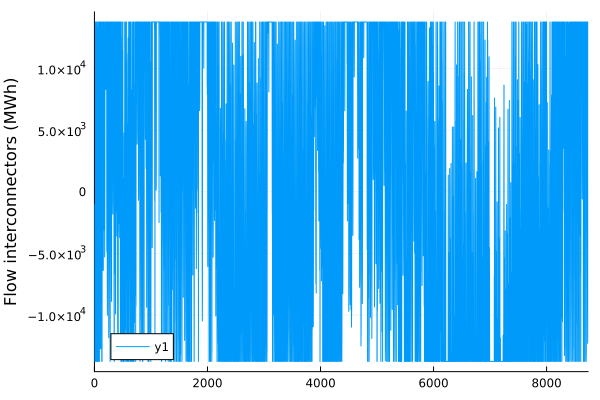

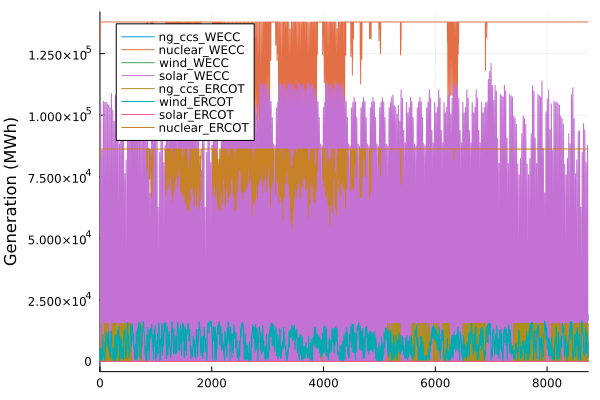

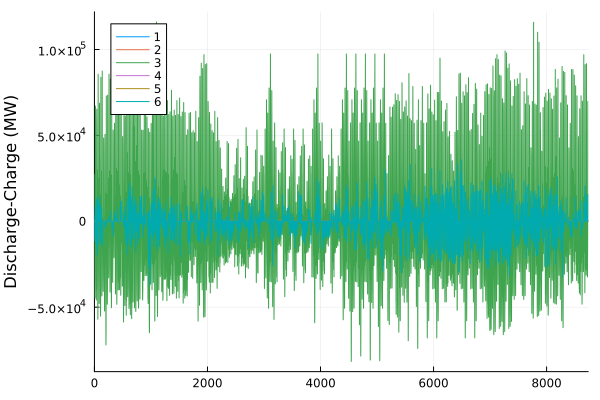

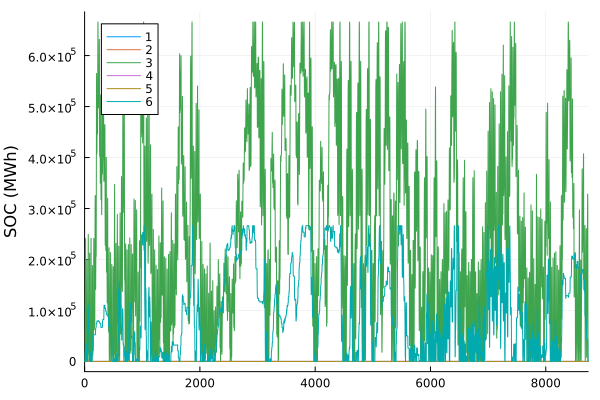

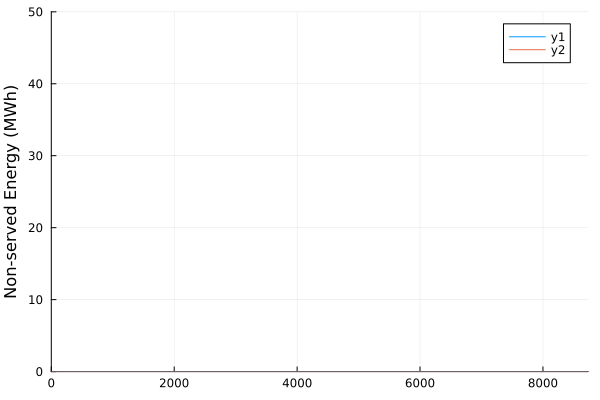

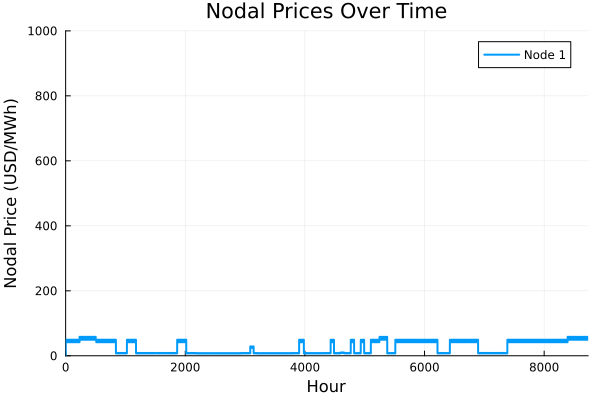

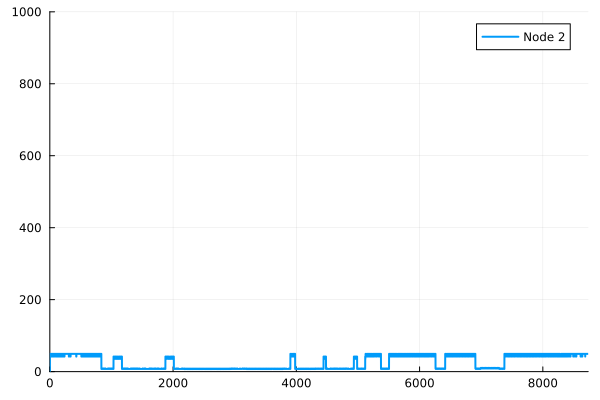

In [37]:
# plots
x1,x2 = 0, 8736

p1 = plot( H, [value.(FLOW).data], ylabel="Flow interconnectors (MWh)",xlims=(x1,x2))

p2 = plot( H, [value.(GEN[:,:]).data'], labels =permutedims(T),xlims=(x1,x2), ylabel="Generation (MWh)")

p3 = plot(H, [value.(DISCHARGE[:,:]).data'- value.(CHARGE[:,:]).data'], labels=permutedims(STOR) , ylabel="Discharge-Charge (MW)",xlims=(x1,x2))

p4 = plot( H, [value.(SOC[:,:]).data'], labels=permutedims(STOR) , ylabel="SOC (MWh)",xlims=(x1,x2))

p5=plot( H, value.(NSE).data, ylabel="Non-served Energy (MWh)" ,  legend=:topright, xlims=(x1, x2), ylims=(0, 50))

# Extract nodal prices for each node over time
nodal_prices_node1 = Dict(h => dual(cDemandBalance[h, 1]) for h in H)  # Node 1
nodal_prices_node2 = Dict(h => dual(cDemandBalance[h, 2]) for h in H)  # Node 2

# Convert nodal prices into vectors
nodal_prices_vector1 = [nodal_prices_node1[h] for h in H]
nodal_prices_vector2 = [nodal_prices_node2[h] for h in H]


# Create DataFrame (optional, if needed for further analysis)
nodal_prices_df = DataFrame(
    Hour = H,
    Node_1 = nodal_prices_vector1,
    Node_2 = nodal_prices_vector2,

)

# Plot nodal prices for Node 1, Node 2, and Node 3
p6 = plot(H, nodal_prices_vector1, xlabel="Hour", ylabel="Nodal Price (USD/MWh)", 
           title="Nodal Prices Over Time", label="Node 1", lw=2, 
           xlims=(x1, x2), ylims=(0, 1000), legend=:topright)

p7 = plot(H, nodal_prices_vector2,xlims=(x1, x2),ylims=(0, 1000), label="Node 2", lw=2);

#Display plots
display(p1)
display(p2)
display(p3)
display(p4)
display(p5)
display(p6)
display(p7)